# ♻️ Distribuição Inteligente de Produtos Sustentáveis 🔋

## 1.Introdução Geral 📄

### 1.1. Objetivo 🎯

Neste projeto, buscamos otimizar a distribuição de recursos essenciais em grandes cidades, com foco em estações de carregamento de carros elétricos e kits médicos móveis. A escolha das áreas mais estratégicas baseia-se em dados de densidade populacional, localização de veículos elétricos e áreas de risco. A otimização é feita de forma eficiente e sustentável, com a finalidade de melhorar a infraestrutura urbana e a saúde pública.



### 1.2. Desafios 🗻

- **Desafio 1 - Estações de Carregamento de Carros Elétricos:** Aumentar a infraestrutura para veículos elétricos em áreas de alta demanda, onde a concentração de carros elétricos é alta.

- **Desafio 2 - Distribuição de Kits Médicos:** Identificar zonas de risco e garantir que os kits médicos móveis cheguem rapidamente a essas áreas durante emergências.

## 2.Métodos Utilizados 🔎

✅ **List Comprehension:** forma compacta de criar listas em Python, substituindo loops tradicionais. Deixa o código mais limpo e eficiente.

✅ **Memoization:** técnica de otimização que armazena os resultados de funções já calculadas para evitar repetições, acelerando o desempenho.

✅ **Mapa com Folium:** uso da biblioteca Folium para criar mapas interativos em Python, facilitando a visualização.

✅ **Algoritmos Ambiciosos (Greedy):** algoritmos que tomam decisões locais ótimas a cada passo, buscando uma solução eficiente no final. São simples e rápidos para certos tipos de problemas.

✅ **Grafos:** estrutura usada para representar conexões entre elementos (como rotas, redes ou caminhos). Muito útil em problemas de caminho mínimo e análise de redes.

- **Cobertura Completa de todas as regiões:** Como as áreas de interesse são grandes e complexas, a modelagem do problema não consegue cobrir todas as ruas e regiões detalhadamente. Vamos usar áreas limitadas para concentrar a análise em pontos-chave.

- **Otimização de todos os parâmetros:** Embora as estratégias gulosas ajudem, a solução ótima global pode não ser alcançada, já que estamos priorizando eficiência ao invés de precisão máxima.

## 3.Preparação de Dados Comum 🗂️


### 3.1. Baixando biblioteca 📚

Para este projeto, utilizaremos a biblioteca osmnx para baixar os grafos dessas cidades, mas antes é necessário baixar neste projeto.

In [ ]:
!pip install osmnx

### 3.2. Importando bibliotecas 📑

In [ ]:
import osmnx as ox
import networkx as nx
import folium
from functools import wraps
from geopy.distance import geodesic
import time
import hashlib
import pickle
import os
import tracemalloc
import math
import numpy as np
from graphviz import Digraph
from IPython.display import Image

### 3.3. Decorator para Memoization e Time

Aqui criaremos o decorators para implementar o memoization, a medição de tempo e memória. Esses decorators seram responsáveis por armazenar os resultados das chamadas de função para evitar refazer os downloads dos grafos e medir o tempo e memória de execução da função de download do grafo.


In [ ]:
# Formatação de Bytes
def formatar_bytes(tamanho_bytes: int) -> str:
    """
    Formata o tamanho em bytes para uma string legível em unidades de armazenamento (KB, MB, GB, etc.).

    Parameters:
    tamanho_bytes (int): O tamanho em bytes a ser formatado.

    Returns:
    str: O tamanho formatado como uma string legível.
    """
    # Definindo as unidades
    unidades = ['Bytes', 'KB', 'MB', 'GB', 'TB', 'PB']

    # Identificando o índice da unidade adequada
    if tamanho_bytes == 0:
        return "0 Bytes"

    i = int(math.floor(math.log(tamanho_bytes, 1024)))
    tamanho_formatado = round(tamanho_bytes / math.pow(1024, i), 2)

    # Retorna o tamanho formatado com a unidade correspondente
    return f"{tamanho_formatado} {unidades[i]}"

# 🧭 Decorator para Memoização (Cache)
def memoize(func):
    """Armazena resultados de chamadas anteriores para evitar cálculos repetidos."""
    cache = {}

    @wraps(func)
    def wrapper(*args):
        if args in cache:
            return cache[args]
        cache[args] = func(*args)
        return cache[args]

    return wrapper

# 🕒 Decorator para Medição de Tempo
def medir_tempo(func):
    """Mede e exibe o tempo de execução da função."""

    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        duration = end - start
        print("\n⏱️ Tempo de Execução")
        print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
        print(f"📌 Função : {func.__name__}")
        print(f"⏲️  Duração: {duration:.4f} segundos")
        print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
        return result

    return wrapper

# Decorador de Medição de Uso de Memória
def memory_usage(func):
    """Mede o uso de memória de uma função usando 'tracemalloc'."""

    @wraps(func)
    def wrapper(*args, **kwargs):
        tracemalloc.start()
        result = func(*args, **kwargs)
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()

        print("\n🧠 Uso de Memória")
        print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
        print(f"📌 Função : {func.__name__}")
        print(f"📦 Atual  : {formatar_bytes(current)} KB")
        print(f"🚀 Pico   : {formatar_bytes(peak)} KB")
        print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
        return result

    return wrapper

### 3.2. Baixando os Grafos das Cidades 📥

Primeiramente, vamos definir as áreas limitadas (bounding boxes) para as cidades-alvo: São Francisco, Nova Délhi e Pequim. Isso reduzirá a quantidade de dados a ser processada, garantindo maior eficiência.

In [ ]:
# Definindo os centros das cidades e o raio (em metros)
CENTROS_CIDADES = {
    'São Francisco': {'lat': 37.7749, 'lon': -122.4194, 'raio': 2000},  # Centro de São Francisco
    'Nova Délhi': {'lat': 28.6139, 'lon': 77.2090, 'raio': 2000},  # Centro de Nova Délhi
    'Pequim': {'lat': 39.9042, 'lon': 116.4074, 'raio': 2000},  # Centro de Pequim
}


@memoize
@medir_tempo
@memory_usage
def baixar_grafo_central(cidade: str):
    """
    Baixa o grafo de uma cidade com base no centro e raio especificados.

    Parameters:
    cidade (str): Nome da cidade.
    centros (dict): Dicionário contendo a latitude, longitude e raio de cada cidade.

    Returns:
    Grafo: Grafo de ruas da cidade dentro do raio especificado.
    """
    lat = CENTROS_CIDADES[cidade]['lat']
    lon = CENTROS_CIDADES[cidade]['lon']
    raio = CENTROS_CIDADES[cidade]['raio']

    # Baixando o grafo usando o centro da cidade e o raio
    grafo = ox.graph_from_point((lat, lon), dist=raio, network_type='drive')
    return grafo

### 3.3. Medição de Tempo e Memória ⏱️

Agora, vamos medir o tempo de execução de cada download de grafo, usando o time para verificar o desempenho.

In [ ]:
# Medindo o tempo e memória para cada cidade
print(" > São Francisco < ")
grafo_sf = baixar_grafo_central('São Francisco')
print(" > Nova Délhi < ")
grafo_nd = baixar_grafo_central('Nova Délhi')
print(" > Pequim < ")
grafo_pq = baixar_grafo_central('Pequim')


 > São Francisco < 

🧠 Uso de Memória
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📌 Função : baixar_grafo_central
📦 Atual  : 12.04 MB KB
🚀 Pico   : 71.52 MB KB
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

⏱️ Tempo de Execução
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📌 Função : baixar_grafo_central
⏲️  Duração: 39.0676 segundos
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
 > Nova Délhi < 

🧠 Uso de Memória
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📌 Função : baixar_grafo_central
📦 Atual  : 21.43 MB KB
🚀 Pico   : 41.63 MB KB
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

⏱️ Tempo de Execução
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📌 Função : baixar_grafo_central
⏲️  Duração: 15.0831 segundos
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
 > Pequim < 

🧠 Uso de Memória
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📌 Função : baixar_grafo_central
📦 Atual  : 13.21 MB KB
🚀 Pico   : 23.76 MB KB
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

⏱️ Tempo de Execução
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📌 Função : baixar_grafo_central
⏲️  Duração: 11.1038 segundos
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


#### 3.3.1. Observações 🌍

Observamos que o tempo de execução para São Francisco é consistentemente maior em comparação com as outras cidades. Isso pode ser explicado pelo fato de que a biblioteca contém mais dados de São Francisco, pois todas as cidades estão limitadas à mesma quantidade de raios. Outra possibilidade é que o centro de São Francisco tenha mais ruas dentro do raio estabelecido em relação às outras cidades. Esse mesma situação acontece com a memória utilizada pelo programa.

## 4.Desafio 1: Alocação de Estações de Carregamento Elétrico 🧑‍💻

Com o crescimento da frota de veículos elétricos nas grandes cidades, a infraestrutura para carregar esses veículos se torna essencial para garantir a mobilidade urbana sustentável. No entanto, o planejamento da localização das estações de carregamento vai além da simples distribuição geográfica. É fundamental que essas estações sejam posicionadas estrategicamente em vias que possibilitem acesso fácil e seguro, evitando ruas inadequadas como rotatórias, áreas de estacionamento proibido ou de difícil acesso.


O objetivo é otimizar a distribuição de estações de forma a cobrir as regiões de maior demanda, ao mesmo tempo em que respeita as condições urbanísticas e de tráfego. Esse desafio envolve não só a escolha das localizações, mas também a análise das características das vias e da acessibilidade para os motoristas, promovendo uma rede de carregamento eficiente e acessível.


Neste código, possuí um código inicial para a instalação de estações de carregamento elétrico em três cidades.

In [ ]:
@medir_tempo
@memory_usage
def alocar_estacoes(grafo: nx.Graph, raio_cobertura: float) -> list:
    """
    Aloca estações apenas entre vias relevantes, evitando caminhos de terra e áreas verdes.

    Parameters:
    grafo (nx.Graph): Grafo da cidade.
    raio_cobertura (float): Raio mínimo entre estações (em metros).

    Returns:
    list of tuples: Coordenadas das estações alocadas.
    """
    estacoes = []
    vias_relevantes = {'primary', 'secondary', 'tertiary', 'trunk', 'motorway'}

    for u, v, data in grafo.edges(data=True):
        # Verifica se é uma via relevante
        tipo_via = data.get('highway')
        if isinstance(tipo_via, list):
            tipo_via = tipo_via[0]
        if tipo_via not in vias_relevantes:
            continue

        # Coordenadas dos nós
        lat_u, lon_u = grafo.nodes[u]['y'], grafo.nodes[u]['x']
        lat_v, lon_v = grafo.nodes[v]['y'], grafo.nodes[v]['x']

        # Ponto médio geográfico
        lat_medio = (lat_u + lat_v) / 2
        lon_medio = (lon_u + lon_v) / 2
        candidato = (lat_medio, lon_medio)

        # Verifica distância mínima
        if all(geodesic(candidato, e).meters >= raio_cobertura for e in estacoes):
            estacoes.append(candidato)

    print(f"🚗 Estações alocadas: {len(estacoes)}")
    return estacoes


# Visualização com folium
def plotar_estacoes(grafo: nx.Graph, estacoes: list, cidade: str):
    """Plota as estações no mapa da cidade."""
    centro = CENTROS_CIDADES[cidade]
    mapa = folium.Map(location=[centro['lat'], centro['lon']], zoom_start=14, tiles="CartoDB positron")


    # Nós do grafo como zonas de demanda (visual)
    [folium.CircleMarker(location=[grafo.nodes[n]['y'], grafo.nodes[n]['x']],
                         radius=2, color='orange', fill=True, fill_opacity=0.4).add_to(mapa)
     for n in grafo.nodes]

    # Estações
    [folium.Marker(location=[lat, lon], icon=folium.Icon(color='green', icon='bolt', prefix='fa')).add_to(mapa)
     for lat, lon in estacoes]

    return mapa

### 4.1. Mapa de Estações em São Francisco 🌎

In [ ]:
cidade = 'São Francisco'
estacoes_sf = alocar_estacoes(grafo_sf, raio_cobertura=500)
plotar_estacoes(grafo_sf, estacoes_sf, cidade)

🚗 Estações alocadas: 45

🧠 Uso de Memória
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📌 Função : alocar_estacoes
📦 Atual  : 37.25 KB KB
🚀 Pico   : 102.5 KB KB
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

⏱️ Tempo de Execução
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📌 Função : alocar_estacoes
⏲️  Duração: 28.4864 segundos
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


### 4.2. Mapa de Estações em Nova Délhi 🐄

In [ ]:
cidade = 'Nova Délhi'
estacoes_nd = alocar_estacoes(grafo_nd, raio_cobertura=500)
plotar_estacoes(grafo_nd, estacoes_nd, cidade)

🚗 Estações alocadas: 39

🧠 Uso de Memória
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📌 Função : alocar_estacoes
📦 Atual  : 125.76 KB KB
🚀 Pico   : 192.93 KB KB
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

⏱️ Tempo de Execução
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📌 Função : alocar_estacoes
⏲️  Duração: 13.7924 segundos
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


### 4.3. Mapa de Estações em Pequim

In [ ]:
cidade = 'Pequim'
estacoes_pq = alocar_estacoes(grafo_pq, raio_cobertura=500)
plotar_estacoes(grafo_pq, estacoes_pq, cidade)

🚗 Estações alocadas: 37

🧠 Uso de Memória
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📌 Função : alocar_estacoes
📦 Atual  : 249.96 KB KB
🚀 Pico   : 317.7 KB KB
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

⏱️ Tempo de Execução
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📌 Função : alocar_estacoes
⏲️  Duração: 9.5285 segundos
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


### 4.4. Conslusões ✅

- **Uso de Memória e Tempo de Execução:** poderiamos ver uma relação que quanto mais estações são foram alocadas maior foi o tempo de execução, pois o algoritmo feito leva em conta que os pontos não podem estar em avenidas. Entretanto, em Nova Délhi e Pequim, é possível ver que algumas estações foram alocadas em localidades estranhas, a solução para esse problema será abordado no próximo tópico.

- **Número de Estações:** o maior número de estações em São Francisco em comparação as outras pode ser devido ao número de nós nos grafos da biblioteca que baixamos.


### 4.5. Melhorias para o Futuro ⭐

Como não tivemos muito tempo para fazer o código, se tivessemos mais tempo fariámos:

1. **Análise de Dados mais profunda:** para delimitar uma área que realmente abrange o público que haja carros eletricos ou uma área que tenha alta demanda para isso, poderiamos fazer ,utilizando o `folium` para visualização, um gráfico de bolha de densidade de dados de riqueza de uma região (lat e long) e ,baseado onde essas regiões estejam, atribuimos as estações próxima dessas regiões.

  *Exemplo de Código de Mapa:*

  ```python
  import folium
  from folium.plugins import MarkerCluster
  import random

  # Geração de pontos aleatórios ao redor de um centro
  def gerar_pontos_aleatorios(lat_centro, lon_centro, num_pontos):
      pontos = []
      for _ in range(num_pontos):
          lat = lat_centro + random.uniform(-0.01, 0.01)
          lon = lon_centro + random.uniform(-0.01, 0.01)
          pontos.append((lat, lon))
      return pontos

  # Exemplo: pontos ao redor de São Paulo
  centro_sp = (-23.5505, -46.6333)
  pontos = gerar_pontos_aleatorios(*centro_sp, 200)

  # Criar mapa base
  mapa = folium.Map(location=centro_sp, zoom_start=13)

  # Agrupar pontos em clusters para contagem de densidade
  cluster = {}
  raio = 0.005  # Raio aproximado de agrupamento (em graus, não metros)

  for lat, lon in pontos:
      key = (round(lat / raio), round(lon / raio))
      cluster[key] = cluster.get(key, 0) + 1

  # Desenhar bolas de densidade com raio proporcional à contagem
  for (lat_k, lon_k), contagem in cluster.items():
      lat_central = lat_k * raio
      lon_central = lon_k * raio
      folium.Circle(
          location=(lat_central, lon_central),
          radius=contagem * 10,  # escala de raio
          color='red',
          fill=True,
          fill_opacity=0.4,
          popup=f'{contagem} ponto(s)'
      ).add_to(mapa)

  mapa

  ```

2. **Estações alocadas em ruas não principais:** algumas estações estão localizadas em áreas inadequadas, como rotatórias ou em cima de prédios, onde não é possível estacionar. Para contornar isso, é necessário filtrar ruas que permitam estacionamento e estejam em vias adequadas para alocação. A solução seria implementar um processo de verificação de ruas com base em parâmetros do OpenStreetMap, como a categoria da via (ex: `highway`, `access`) e a presença de áreas restritas. Dessa forma, garantiríamos que as estações sejam posicionadas apenas em locais onde o estacionamento é permitido.

3. **Adicionar limites:** é importante considerar restrições financeiras ao alocar estações, baseando-se no custo unitário de instalação e no orçamento total disponível pela prefeitura ou empresa. Para isso, seria necessário definir um custo por estação e interromper a alocação quando a soma dos custos atingir o teto orçamentário, garantindo uma distribuição eficiente e financeiramente viável.

4. **Pontos de Estações no Meio da Rua:** algumas estações estão posicionadas bem no meio da rua, o que não representa uma localização viável para parada de veículos. Além disso, em vias de mão dupla, seria necessário considerar pontos de ambos os lados da rua, pois nem sempre há travessias ou retornos próximos. Para resolver isso, seria necessário utilizar dados de geometrias das vias (como `edge['geometry']`) para identificar a lateral da rua onde há calçada ou área de estacionamento, garantindo que os pontos de alocação fiquem em locais acessíveis e seguros para os motoristas.

## 5.Desafio 2: Alocação de Kits Médicos Móveis 🚑

Este código representa uma implementação inicial de um sistema de apoio à decisão para a alocação estratégica de kits médicos móveis em ambientes urbanos, utilizando como base a malha viária real extraída por meio da biblioteca osmnx. A proposta é fornecer uma primeira versão funcional de um algoritmo que possa ser expandido e refinado conforme os requisitos de aplicação evoluam.

A lógica empregada busca posicionar os kits médicos em locais de alta relevância viária e potencial densidade populacional, com base em heurísticas simples como o grau dos nós e o tipo da via. As vias consideradas prioritárias (como 'primary', 'secondary', 'trunk', entre outras) são avaliadas quanto à média de conectividade dos seus nós extremos, e os kits são distribuídos ao longo dessas arestas, respeitando um raio mínimo de cobertura entre eles.

O sistema também oferece uma visualização interativa em mapa, com a numeração sequencial dos kits alocados para facilitar a análise e possíveis ajustes manuais ou automáticos no futuro. Os nós da cidade são desenhados com círculos proporcionais ao seu grau, evidenciando regiões com maior concentração de conexões.

Embora funcional, este código é um protótipo exploratório, e há espaço para melhorias significativas.

O objetivo desta versão é servir de base para iterações futuras, possibilitando testes em diferentes cenários urbanos e a validação de abordagens mais avançadas com base em dados reais.



In [ ]:
@memoize
def encontrar_no_mais_proximo(lat: float, lon: float, grafo: nx.Graph) -> int:
    """
    Encontra o nó mais próximo no grafo para uma coordenada geográfica.

    Parâmetros:
    - lat (float): Latitude.
    - lon (float): Longitude.
    - grafo (nx.Graph): Grafo da cidade.

    Retorno:
    - int: ID do nó mais próximo.
    """
    return ox.distance.nearest_nodes(grafo, X=lon, Y=lat)

@medir_tempo
@memory_usage
def alocar_kits_medicos(grafo: nx.Graph, raio_cobertura: float, max_kits: int = 50) -> list:
    """
    Aloca kits médicos móveis em nós estratégicos do grafo da cidade, priorizando vias de alta relevância
    e regiões com alto grau de conectividade (heurística para densidade populacional).

    Parâmetros:
    grafo (nx.Graph): Grafo da cidade com atributos OSM.
    raio_cobertura (float): Distância mínima entre kits (em metros).
    max_kits (int): Número máximo de kits a serem alocados.

    Retorna:
    list: Lista com coordenadas (lat, lon) dos kits alocados.
    """
    kits = []
    vias_relevantes = {'primary', 'secondary', 'tertiary', 'trunk', 'motorway'}

    # Peso dos nós com base no grau (número de conexões)
    pesos_nos = {n: grafo.degree(n) for n in grafo.nodes}

    # Seleciona arestas em vias relevantes e calcula o peso médio dos nós conectados
    arestas_filtradas = [
        (u, v, data, (pesos_nos[u] + pesos_nos[v]) / 2)
        for u, v, data in grafo.edges(data=True)
        if (tipo := data.get('highway', '')) and (
            tipo[0] if isinstance(tipo, list) else tipo
        ) in vias_relevantes
    ]

    # Ordenar arestas por maior peso (mais relevantes)
    arestas_filtradas.sort(key=lambda x: x[3], reverse=True)

    for u, v, data, _ in arestas_filtradas:
        if len(kits) >= max_kits:
            break

        # Escolhe o nó mais conectado entre os dois (melhor representatividade)
        no_escolhido = u if pesos_nos[u] >= pesos_nos[v] else v
        coord_kit = (
            grafo.nodes[no_escolhido]['y'],
            grafo.nodes[no_escolhido]['x']
        )

        # Garante que o novo kit esteja distante o suficiente dos demais
        if all(geodesic(coord_kit, existente).meters >= raio_cobertura for existente in kits):
            kits.append(coord_kit)

    print(f"🚑 Kits médicos alocados: {len(kits)}")
    return kits


def plotar_kits_medicos(grafo: nx.Graph, kits: list, cidade: str) -> folium.Map:
    """
    Plota os kits médicos em um mapa interativo, junto com os nós do grafo como zonas de demanda.

    Parâmetros:
    grafo (nx.Graph): Grafo da cidade.
    kits (list): Lista de coordenadas dos kits alocados.
    cidade (str): Nome da cidade (usado para centralizar o mapa).

    Retorna:
    folium.Map: Mapa com os kits e zonas de demanda plotados.
    """
    centro = CENTROS_CIDADES[cidade]
    mapa = folium.Map(location=[centro['lat'], centro['lon']], zoom_start=14, tiles="CartoDB positron")

    # Marcadores de kits
    [folium.Marker(
        location=[lat, lon],
        icon=folium.Icon(color='red', icon='plus', prefix='fa'),
        popup='Kit Médico'
    ).add_to(mapa) for lat, lon in kits]

    # Adiciona rotas entre os kits
    for i in range(len(kits) - 1):
        lat1, lon1 = kits[i]
        lat2, lon2 = kits[i + 1]
        try:
            no_inicio = encontrar_no_mais_proximo(lat1, lon1, grafo)
            no_fim = encontrar_no_mais_proximo(lat2, lon2, grafo)
            rota = nx.shortest_path(grafo, no_inicio, no_fim, weight='length')
            pontos = [(grafo.nodes[n]['y'], grafo.nodes[n]['x']) for n in rota]
            folium.PolyLine(locations=pontos, color='green', weight=3, opacity=0.7).add_to(mapa)
        except Exception as e:
            print(f"Erro ao traçar rota entre kits {i} e {i + 1}: {e}")

    # Adiciona marcadores dos kits com numeração para indicar a ordem
    for idx, (lat, lon) in enumerate(kits, start=1):
        folium.Marker(
            location=[lat, lon],
            icon=folium.DivIcon(
                html=f"""<div style="font-size: 12pt; color: red;"><b>{idx}</b></div>"""
            ),
            popup=f"Kit Médico #{idx}"
        ).add_to(mapa)

    return mapa

### 5.1. Mapa de Rota de Kit Médicos Móveis em São Francisco 🛣️

In [ ]:
# Executando para São Francisco
cidade = 'São Francisco'
kits_sf = alocar_kits_medicos(grafo_sf, raio_cobertura=500, max_kits=10)
mapa_kits = plotar_kits_medicos(grafo_sf, kits_sf, cidade)
mapa_kits

🚑 Kits médicos alocados: 10

🧠 Uso de Memória
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📌 Função : alocar_kits_medicos
📦 Atual  : 43.2 KB KB
🚀 Pico   : 218.51 KB KB
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

⏱️ Tempo de Execução
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📌 Função : alocar_kits_medicos
⏲️  Duração: 0.1924 segundos
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


### 5.2. Mapa de Rota de Kit Médicos Móveis em Nova Délhi ⚡

In [ ]:
# Executando para Nova Délhi
cidade = 'Nova Délhi'
kits_nd = alocar_kits_medicos(grafo_nd, raio_cobertura=500, max_kits=10)
mapa_kits = plotar_kits_medicos(grafo_nd, kits_nd, cidade)
mapa_kits

🚑 Kits médicos alocados: 10

🧠 Uso de Memória
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📌 Função : alocar_kits_medicos
📦 Atual  : 14.17 KB KB
🚀 Pico   : 86.92 KB KB
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

⏱️ Tempo de Execução
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📌 Função : alocar_kits_medicos
⏲️  Duração: 0.1640 segundos
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


### 5.3. Mapa de Rota de Kit Médicos Móveis em Pequim ⛩

In [ ]:
# Executando para Pequim
cidade = 'Pequim'
kits_pq = alocar_kits_medicos(grafo_pq, raio_cobertura=500, max_kits=10)
mapa_kits = plotar_kits_medicos(grafo_pq, kits_pq, cidade)
mapa_kits

🚑 Kits médicos alocados: 10

🧠 Uso de Memória
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📌 Função : alocar_kits_medicos
📦 Atual  : 23.2 KB KB
🚀 Pico   : 87.11 KB KB
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

⏱️ Tempo de Execução
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📌 Função : alocar_kits_medicos
⏲️  Duração: 0.1780 segundos
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


### 5.4. Conclusões ✅

- **Uso de Memória e Tempo de Execução:** Diferentemente do Desafio 1, neste caso foi imposta uma limitação na quantidade de kits médicos alocados para evitar que a visualização da rota se tornasse confusa. Por isso, os dados apresentados representam uma aproximação do tempo de execução e do uso de memória da função de alocação.

- **Ruas Curvas:** Também é possível notar que, em ruas curvas ou com rotatórias, as linhas podem atravessar calçadas, já que os pontos são conectados por linhas retas sem considerar a geometria real da via.

### 5.5. Melhorias para o Futuro 🌟

Como não tivemos muito tempo para fazer o código, se tivessemos mais tempo fariámos:

- **Análise de Dados:** como no desafio 1, o ideal seria analisar onde o impacto de doenças ou indices de mortes seriam os maiores para focarmos em rotas para aquelas áreas específicas.

- **Considerar Ruas Curvas**: para representar melhor curvas e rotatórias, uma das soluções é usar interpolação com splines no Python (via `scipy.interpolate`), criando linhas curvas suaves entre os pontos ao invés de linhas retas, o que melhora a visualização do trajeto.


* **Melhoria na Alocação de Kits Médicos:** Com mais tempo, seria interessante adicionar uma análise espacial mais detalhada, considerando dados de densidade populacional, áreas de alta vulnerabilidade e proximidade de hospitais ou centros de saúde, para otimizar a distribuição dos kits e maximizar a cobertura efetiva.

* **Otimização de Rota com Algoritmos Avançados:** Embora o código utilize a função de caminho mais curto, a implementação de algoritmos mais sofisticados (como A\* ou Dijkstra com heurísticas aprimoradas) poderia reduzir o tempo de execução, especialmente para grandes grafos.

* **Integração com Dados em Tempo Real:** Outra melhoria seria a integração com dados em tempo real, como condições de tráfego ou emergências médicas, para ajustar dinamicamente as rotas dos kits médicos e garantir a maior eficiência na distribuição.

* **Simulação de Demanda:** Caso tivéssemos mais tempo, poderíamos implementar uma simulação de demanda de kits médicos, onde as áreas com maior necessidade seriam priorizadas de acordo com fatores como número de incidentes ou doenças em curso, ajudando a direcionar os kits para onde realmente são mais necessários.

* **Consideração de Restrições Urbanas e Geográficas:** Outra melhoria importante seria a consideração de restrições físicas e geográficas das vias (como ruas bloqueadas, áreas de difícil acesso, etc.), que poderiam ser incorporadas no grafo para impedir que rotas sejam geradas através de locais intransitáveis.

* **Aprimoramento na Visualização do Mapa:** Melhorar a visualização do mapa, incluindo a personalização dos ícones dos kits médicos, adição de informações contextuais sobre cada rota e kit, como tempo estimado de chegada, e até mesmo a exibição de outras informações úteis (ex: hospitais próximos ou rotas alternativas).

## 6.Fluxograma do Código 🗺️

O fluxograma representa a estrutura do código Python do notebook, cobrindo a preparação de dados, download de grafos, alocação de estações de carregamento e distribuição de kits médicos. Primeiro, apresento o código Python que usa a biblioteca graphviz para gerar o fluxograma, seguido de uma explicação do fluxograma gerado.

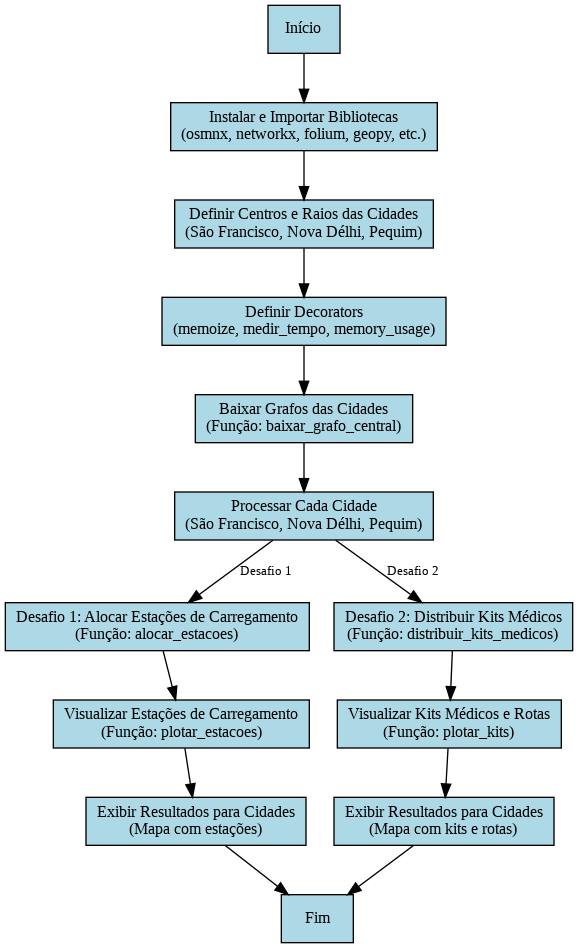

In [ ]:
# Criar o fluxograma
dot = Digraph(comment='Fluxograma do Código', format='png')
dot.attr(rankdir='TB', size='10,15')  # Orientação vertical, tamanho ajustado
dot.attr('node', shape='box', style='filled', fillcolor='lightblue', fontsize='12')
dot.attr('edge', fontsize='10')

# Adicionar nós do fluxograma
dot.node('A', 'Início')
dot.node('B', 'Instalar e Importar Bibliotecas\n(osmnx, networkx, folium, geopy, etc.)')
dot.node('C', 'Definir Centros e Raios das Cidades\n(São Francisco, Nova Délhi, Pequim)')
dot.node('D', 'Definir Decorators\n(memoize, medir_tempo, memory_usage)')
dot.node('E', 'Baixar Grafos das Cidades\n(Função: baixar_grafo_central)')
dot.node('F', 'Processar Cada Cidade\n(São Francisco, Nova Délhi, Pequim)')
dot.node('G1', 'Desafio 1: Alocar Estações de Carregamento\n(Função: alocar_estacoes)')
dot.node('G2', 'Desafio 2: Distribuir Kits Médicos\n(Função: distribuir_kits_medicos)')
dot.node('H1', 'Visualizar Estações de Carregamento\n(Função: plotar_estacoes)')
dot.node('H2', 'Visualizar Kits Médicos e Rotas\n(Função: plotar_kits)')
dot.node('I1', 'Exibir Resultados para Cidades\n(Mapa com estações)')
dot.node('I2', 'Exibir Resultados para Cidades\n(Mapa com kits e rotas)')
dot.node('J', 'Fim')

# Adicionar conexões (arestas)
dot.edge('A', 'B')
dot.edge('B', 'C')
dot.edge('C', 'D')
dot.edge('D', 'E')
dot.edge('E', 'F')
dot.edge('F', 'G1', label='Desafio 1')
dot.edge('F', 'G2', label='Desafio 2')
dot.edge('G1', 'H1')
dot.edge('G2', 'H2')
dot.edge('H1', 'I1')
dot.edge('H2', 'I2')
dot.edge('I1', 'J')
dot.edge('I2', 'J')

# Renderizar o fluxograma e salvar como PNG
dot.render('fluxograma_codigo', cleanup=False)  # Gera fluxograma_codigo.png

# Exibir o fluxograma no notebook
Image(filename='fluxograma_codigo.png')

## 7.Conclusão Final 🏁

O projeto apresenta uma abordagem inovadora para otimizar a distribuição de recursos urbanos, utilizando algoritmos baseados em grafos e análise geoespacial para enfrentar dois desafios críticos: a alocação de estações de carregamento para veículos elétricos e a distribuição de kits médicos móveis. Através da biblioteca osmnx para modelagem de redes viárias e folium para visualização, o notebook fornece uma estrutura prática para planejamento urbano em São Francisco, Nova Délhi e Pequim.

O projeto utiliza modelos simplificados (e.g., raios limitados, algoritmos gulosos), que podem não capturar todas as complexidades urbanas, como tráfego em tempo real ou dados demográficos detalhados. As visualizações, embora eficazes, podem ser aprimoradas para representar vias curvas e fornecer mais informações contextuais. Melhorias futuras, como integração de dados em tempo real, algoritmos avançados (e.g., A*) e análise de demanda, podem tornar o sistema mais robusto e aplicável.

Com isso, o notebook estabelece uma base sólida para iniciativas de cidades inteligentes, demonstrando como abordagens baseadas em dados podem resolver desafios urbanos. Com refinamentos adicionais, o framework pode ser escalado para outras cidades e recursos, contribuindo para esforços globais de sustentabilidade e resiliência urbana. A combinação de rigor técnico e aplicação prática torna este projeto uma valiosa contribuição para o planejamento urbano e a otimização da saúde pública.

## 8.Integrantes 🎭

- **Alice Santos Bulhões** *RM554499*